In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import trange

from IPython.display import clear_output

In [2]:
from datagen import gen_batch
from models.nopool import Model

clear_output()

In [3]:
batch_size = 32
lr = 1e-4
n_iters = 3000

model_name = 'nopool'
model_path = f'saved_models/{model_name}/model'
log_dir = f'logs/{model_name}'

In [4]:
model = Model()
saver = tf.train.Saver()

optimizer = tf.train.AdamOptimizer(lr)
train_step = optimizer.minimize(model.loss)

In [5]:
with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(log_dir, sess.graph)
    sess.run(tf.global_variables_initializer())
    
    for i in trange(n_iters):
        x, y = gen_batch(batch_size=batch_size, fixed_size=True)
        _, summary = sess.run([train_step, model.summary], feed_dict={
            model.x: x,
            model.y: y,
        })
        summary_writer.add_summary(summary, i)
        
        if i % 1000 == 0:
            saver.save(sess, model_path)

100%|██████████| 3000/3000 [02:18<00:00, 21.68it/s]


In [6]:
x, y = gen_batch(batch_size=8, fixed_size=True)
with tf.Session() as sess:
    saver.restore(sess, model_path)
    inference = sess.run(model.inference, feed_dict={
        model.x: x,
        model.y: y,
    })
inference.shape

INFO:tensorflow:Restoring parameters from saved_models/nopool/model


(8, 2)

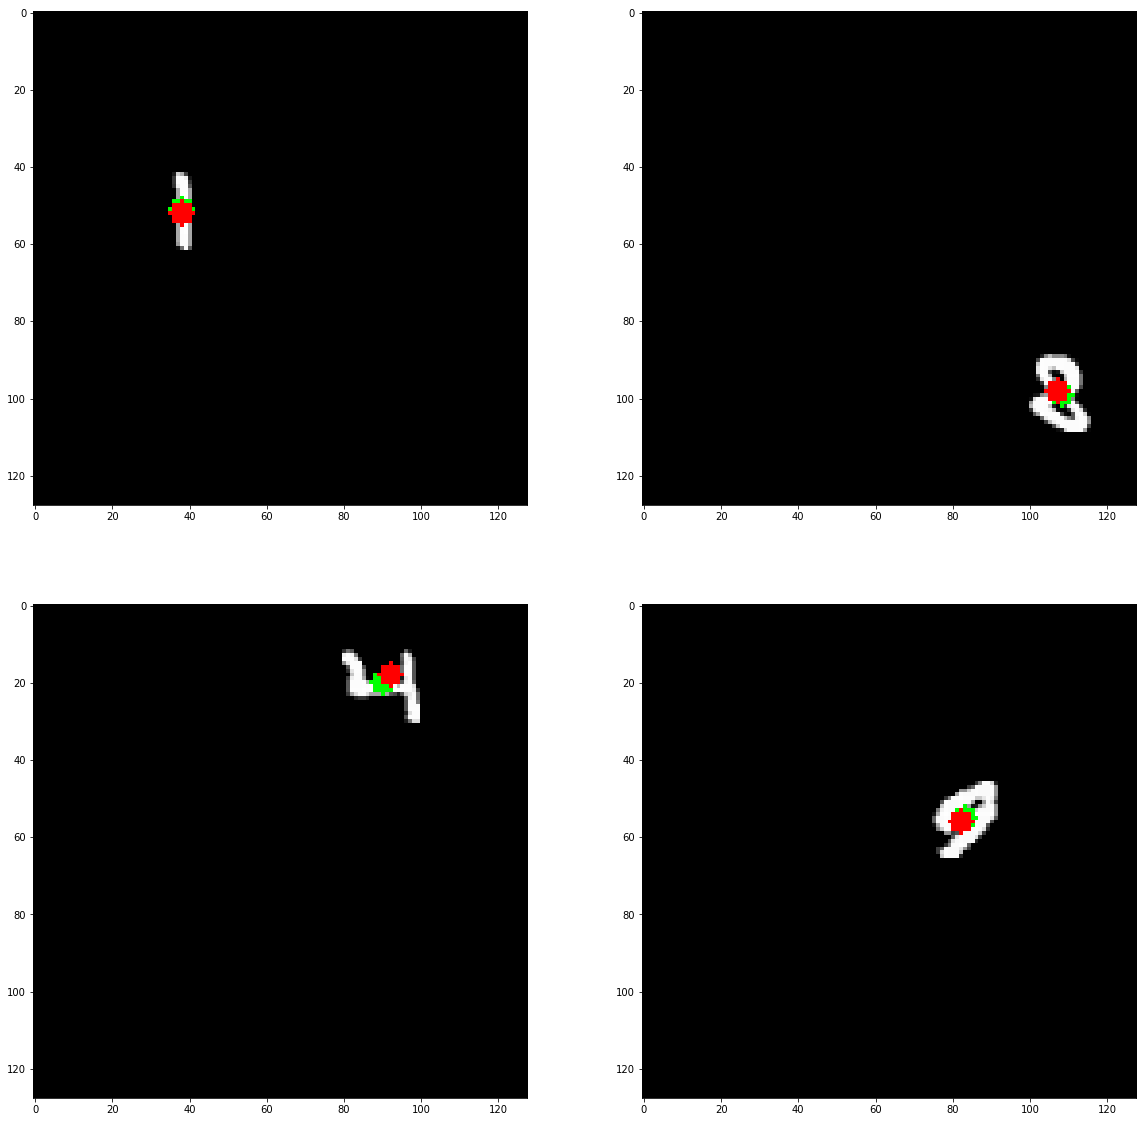

In [7]:
def visualize(image, true, pred):
    """
    image: float image [0, 1], shape [h, w, 1]
    true, false: [x, y], values [0, 1]
    """
    h, w = image.shape[:2]
    true_x, true_y = int(true[0]*w), int(true[1]*h)
    pred_x, pred_y = int(pred[0]*w), int(pred[1]*h)
    
    image = np.squeeze(image, axis=-1)  # remove last channel
    image = (image * 255).astype(np.uint8)  # convert to 8-bit image
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # convert to BGR
    
    cv2.circle(image, (true_x, true_y), 3, (0, 255, 0), -1)
    cv2.circle(image, (pred_x, pred_y), 3, (255, 0, 0), -1)
    return image

plt.figure(figsize=(20, 20))
for i in range(4):
    out = visualize(x[i], y[i], inference[i])
    plt.subplot(2, 2, i+1)
    plt.imshow(out)
plt.show();